In [1]:
!unzip Images.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms

C:\Users\62819\anaconda3\envs\data-scientist\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torchvision

In [4]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cpu


# Read a batch of training image

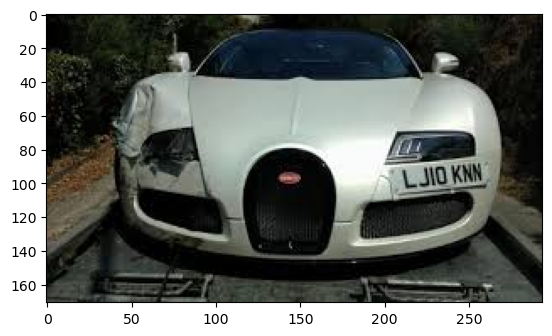

In [5]:
img0 = cv2.imread('0298.jpeg')
img0 = cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)
plt.imshow(img0)

In [6]:
bbox0 = np.array([[40,30,120,80],[125,55,140,95]]) 
labels = np.array([1,1]) # 1: damage , 1: damage

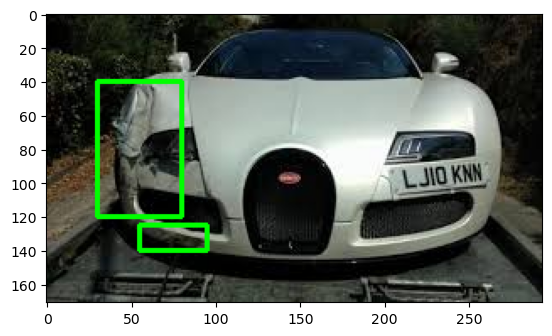

In [7]:
img0_copy = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_copy, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]),color=(0,255,0),thickness=2)
plt.imshow(img0_copy)
plt.show()

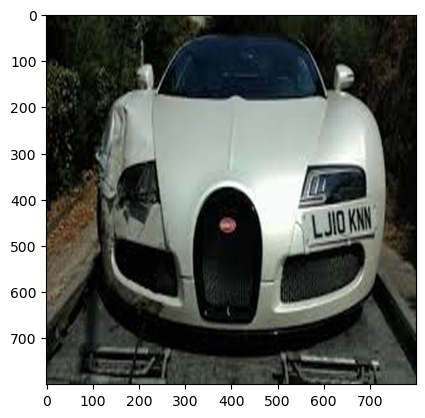

In [8]:
img = cv2.resize(img0,dsize=(800,800),interpolation= cv2.INTER_CUBIC)
plt.imshow(img)
plt.show()

In [9]:
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioList = [Hratio,Wratio,Hratio,Wratio]
bbox = []
for box in bbox0:
    box = [int(a*b) for a,b in zip(box,ratioList)]
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[187  81 561 217]
 [584 149 654 258]]


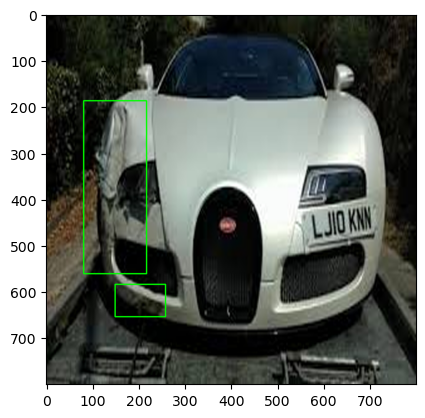

In [10]:
img_copy = np.copy(img)
bbox_copy = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_copy, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]),color=(0,255,0),thickness=2)
plt.imshow(img_copy)
plt.show()

# use VGG-16 to extract features

In [11]:
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)

C:\Users\62819\anaconda3\envs\data-scientist\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\62819\anaconda3\envs\data-scientist\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
print(len(fe))

31


In [13]:
dummy_imgs = torch.zeros((1,3,800,800)).float()

In [14]:
k = dummy_imgs.clone().to(device)

In [15]:
req_features = []

In [16]:
req_features

[]

In [17]:
for i in fe:
    k = i(k)
    if k.size()[2]< 800//16:
        break
    
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features))
print(out_channels)

30
512


In [18]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

Here, we got the feature map (out_map)

In [19]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


In [20]:
fe_size = (800//16)
center_x = np.arange(16,(fe_size+1)*16,16) 
center_y = np.arange(16,(fe_size+1)*16,16)
print(len(center_x),center_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [21]:
#coordinates of the 2500 center points to generate boxes
index = 0
center = np.zeros((2500,2))
for x in range(len(center_x)):
    for y in range(len(center_y)):
        center[index,1] = center_x[x]-8
        center[index,0] = center_y[y]-8
        index +=1
print(center.shape)
        

(2500, 2)


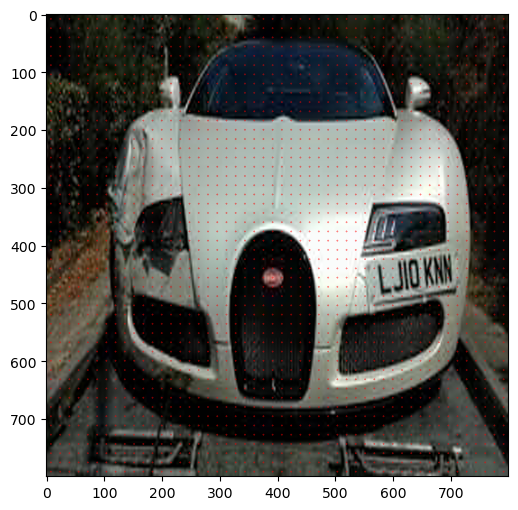

In [22]:
#display the image with center point (anchor boxes)
img_copy = np.copy(img)
plt.figure(figsize=(9,6))
for i in range(center.shape[0]):
    cv2.circle(img_copy,(int(center[i][0]),int(center[i][1])),radius=1,color=(255,0,0),thickness=1)
plt.imshow(img_copy)
plt.show()

In [23]:
#for each anchor, we generates 9 anchor boxes
#2500*9 = 22500 anchor boxes

ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16 #Since we have pooled our image from 800 px to 50px 800/50 = 16
anchor_boxes = np.zeros(((fe_size * fe_size * 9),4))
index = 0
for c in center:
    center_y,center_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1/ ratios[i])
            anchor_boxes[index,0] = center_y - h / 2.
            anchor_boxes[index,1] = center_x - w / 2.
            anchor_boxes[index,2] = center_y + h / 2.
            anchor_boxes[index,3] = center_x + w / 2.
            index+=1
print(anchor_boxes.shape)

(22500, 4)


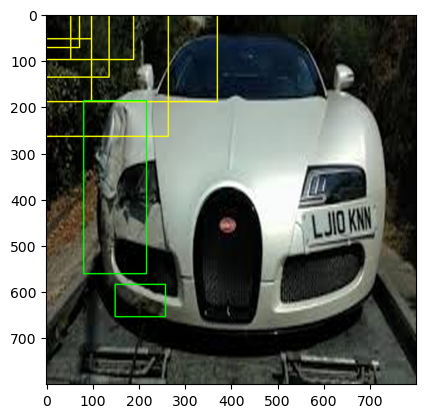

In [24]:
#display 9 anchor boxes, for the first anchor.
img_copy = np.copy(img)
for i in range(0,8):
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_copy,(x0,y0),(x1,y1),color=(255,255,0),thickness=2)
    
for i in range(len(bbox)):
    cv2.rectangle(img_copy, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]),color=(0,255,0),thickness=2)

plt.imshow(img_copy)
plt.show()

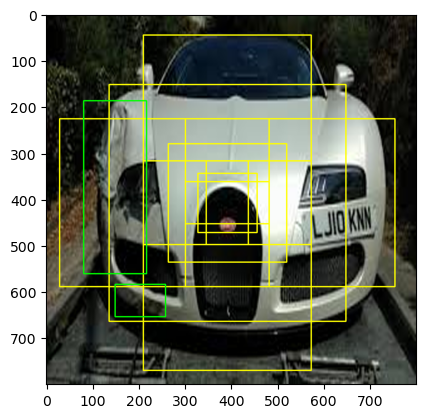

In [25]:
#display 9 anchor box for the center anchor.
img_copy = np.copy(img)
for i in range(11025,11034):
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_copy,(x0,y0),(x1,y1),color=(255,255,0),thickness=2)
    
    
for i in range(len(bbox)):
    cv2.rectangle(img_copy, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]),color=(0,255,0),thickness=2)

plt.imshow(img_copy)
plt.show()

we filter which index are valid (valid index mean the index where the anchor boxes doesnt exceed the image).

In [26]:
#valid anchor boxes with (y1,x1)>0 and (y2,x2)<=800
index_valid = np.where(
    (anchor_boxes[:,0]>=0)&
        (anchor_boxes[:,1]>=0)&
         (anchor_boxes[:,2]<=800)&
         (anchor_boxes[:,3]<=800)
        )[0]

print(index_valid.shape)

(8940,)


In [27]:
#create an empty label array with inside_index shape and fill with -1. 
label = np.empty((len(index_valid),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [28]:
valid_anchor_boxes = anchor_boxes[index_valid]
print(valid_anchor_boxes.shape)

(8940, 4)


In [29]:
#since we have valid anchor boxes 8940 and the ground-truth boxes is 2. we should get ious an array shape (8940,2) 

ious = np.empty((len(valid_anchor_boxes),2),dtype=np.float32)
ious.fill(0)

for num_i,i in enumerate(valid_anchor_boxes):
    
    ya1,xa1,ya2,xa2 = i
    
    #calculate area of anchor boxes
    anchor_area = (ya2-ya1)*(xa2-xa1)
    
    for num_j,j in enumerate(bbox):
        yb1,xb1,yb2,xb2 = j
        #calculate area of ground truth boxes
        box_area = (yb2-yb1)*(xb2-xb1)
        #we calculate coordinate of intersection area
        intersection_x1 = max([xb1,xa1])
        intersection_y1 = max([yb1,ya1])
        intersection_x2 = min([xb2,xa2])
        intersection_y2 = min([yb2,ya2])
        
        if(intersection_x1<intersection_x2) and (intersection_y1<intersection_y2):
            intersection_area = (intersection_y2-intersection_y1)*(intersection_x2-intersection_x1)
            iou = intersection_area /(anchor_area+box_area-intersection_area)
        else:
            iou = 0.
        ious[num_i,num_j] = iou
        
print(ious.shape)

(8940, 2)


In [30]:
#The anchor box that has max IOU that associated with ground truth boxes
#ex: we have 3 anchor box for the specific ground truth box. [0.3,0.5,0.8]. since the 3rd anchor box has IOU 0.8 we take that as gt_argmax_ious
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious,np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[ 589 1032]
[0.7331038  0.46569824]
[ 589  775  961 1032 1254 1478 1482 1484 1490 1495 1710 1938]


In [31]:
#for each anchor box , we tried to find which truth box that the anchor box has the max IOU with.
#ex: anchorbox-01 has 0.37 IOU with truth-box-1(labeled 0) and 0.55 with truth-box-2(labeled 1). then, the argmax_ious is 1.
#since our sample here only has 1 truth box. the argmax_ious will always return 0. 
argmax_ious = ious.argmax(axis=1)
print(argmax_ious)
max_ious = ious[np.arange(len(index_valid)),argmax_ious]
print(max_ious)

[0 0 0 ... 0 0 0]
[0.00226701 0.00713152 0.01204348 ... 0.         0.         0.        ]


In [32]:
#define the IOU values that we considered as positive and negative.
#first we only include highest value of iou to be consider as positive.here, we also consider iou value more than 0.7 as positive.
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3
#Assign positive label (1) to all the anchor boxes which have highest IoU overlap with a ground-truth box
label[gt_argmax_ious] = 1
#Assign positive label (1) to all the anchor boxes which have max_iou greater than positive threshold.
label[max_ious >= pos_iou_threshold] = 1
#Assign negitive label (0) to all the anchor boxes which have max_iou less than negitive threshold.
label[max_ious < neg_iou_threshold] = 0

In [33]:
np.unique(label)

array([-1,  0,  1])

In [34]:
unique, counts = np.unique(label, return_counts=True)

In [35]:
dict(zip(unique, counts))

{-1: 358, 0: 8567, 1: 15}

# mini-batch training  256 valid anchor boxes ( 128 positive examples, 128 negative examples )

In [36]:
n_sample = 256
pos_ratio = 0.5

n_pos = pos_ratio * n_sample
pos_index = np.where(label == 1)[0]

#we disabled some positive sample by change the label to -1, if the positive sample is more than maximum limit(n_pos).
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

n_neg = n_sample * len(np.where(label==1)[0])
#n_neg = len(np.where(label == 1)[0])
neg_index = np.where(label == 0)[0]

#we disabled some negative sample by change the label to -1, if the negative sample is more than maximum limit(n_neg)
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    print("disable index for neg index processed")
    label[disable_index] = -1

disable index for neg index processed


In [37]:
unique, counts = np.unique(label, return_counts=True)

In [38]:
dict(zip(unique,counts))

{-1: 5085, 0: 3840, 1: 15}

In [39]:
len(np.where(label == 1)[0])

15

# Assigning locations to anchor boxes (anchor_locs)

In [40]:
# For each valid anchor box, find the groundtruth object which has max_iou 

max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox)

[[187  81 561 217]
 [187  81 561 217]
 [187  81 561 217]
 ...
 [187  81 561 217]
 [187  81 561 217]
 [187  81 561 217]]


In [41]:
height = valid_anchor_boxes[:,2] - valid_anchor_boxes[:,0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
center_y = valid_anchor_boxes[:, 0] + (0.5 * height)
center_x = valid_anchor_boxes[:, 1] + (0.5 * width)

base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_center_y = max_iou_bbox[:, 0] + (0.5 * base_height)
base_center_x = max_iou_bbox[:, 1] + (0.5 * base_width)

# valid anchor boxes 的 loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
#eps is  the 
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)  
width = np.maximum(width, eps)
dy = (base_center_y - center_y) / height
dx = (base_center_x - center_x) / width
#np.log is natural logarithm log(e) x
#log(e) x= ln x
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)

(8940, 4)


In [42]:
#assign Final labels and final locations
#here final labels contain the fixed labels.
#we will map the label and anchor localtion for valid index that we calculate earlier above to the original anchors using the index_valid variable.
#what difference that we have between valid_anchor_boxes and our final locations is that .valid_anchor_boxes only has the valid one and final locations has both invalid and valid but the locations for invalid are  0.
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_valid] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_valid, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


In [43]:
anchor_boxes.shape[1:]

(4,)

# RPN

we use this RPN to generate 22500 ROI, 
we want to train this RPN to recognize the object we want.

the 22500(8940 valid) anchor box with label that we generate earlier is y-actual 
and the 22500 ROI generated by RPN is y-pred.

In [44]:
in_channels = 512 # depends on the output feature map. in vgg-16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device) # I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [45]:

conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
# Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()
# classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [46]:
x = conv1(out_map) # out_map is obtained in section 1
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_cls_scores.shape, pred_anchor_locs.shape)
#Out:
#torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])

torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])


In [47]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


RPN proposals highly overlap with each other. To reduced redundancy, we adopt non-maximum supression (NMS) on the proposal regions based on their cls scores. We fix the IoU threshold for NMS at 0.7, which leaves us about 2000 proposal regions per image. we use the top-N ranked proposal regions for detection.

In [48]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 4

# 1.convert the loc predictions from the rpn network to bbox [y1, x1, y2, x2] format. 

This is the reverse operations of what we have done while assigning ground truth to anchor boxes .
what we done before is tried to find the anchor_locs(the location of ground truth in respect of specific anchor box).
now , from the prediction we got the pred_locs and we tried to find the predicted boxes .

Convert anchors format from coordinate (y1, x1, y2, x2) to length and center (ctr_x, ctr_y, h, w)

In [49]:
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width

Convert predictions locs using above formulas. before that convert the pred_anchor_locs and objectness_score to numpy array

In [50]:
len(dy)

8940

In [51]:
len(anc_height)

22500

In [52]:
pred_anchor_locs_numpy = pred_anchor_locs[0].data.numpy()
objectness_score_numpy = objectness_score[0].data.numpy()

dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]

h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]

convert center and length format [ctr_x, ctr_y, h, w] to coordinate [y1, x1, y2, x2] format

In [53]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
'''
roi structure {y_min,x_min,y_max,x_max}
'''
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w 

# 2.clip the predicted boxes to the image

In [54]:
img_size = (800, 800) #Image size
#we normalize anchor boxes that goes beyond image-size(800,800) ,if one of predicted box coordinates smaller than 0 or bigger 800.
#smaller than 0 or bigger than 800 mean our coordinate is already out of image frame. 
#example: if one of predicted box has coordinate (-1,-1) we will clipped it to (0,0)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi)

[[  0.           0.          52.57509502  98.88138162]
 [  0.           0.          96.83503816 196.83477513]
 [  0.           0.         200.61160683 371.20005502]
 ...
 [701.76591322 745.10114119 800.         800.        ]
 [614.56208471 698.28245377 800.         800.        ]
 [434.13192593 610.79728409 800.         800.        ]]


# 3.Remove predicted boxes with height and width < threshold.

In [55]:
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]

# 4.Sort all (proposal, score) pairs by score from highest to lowest.

In [56]:
len(score)

22500

In [57]:
#sort the index based on score from highest to lowest
order = score.ravel().argsort()[::-1]
print(order)

[11631 13896 11622 ... 16950 17391 16941]


# 5.Take top of  pre_nms_topN 

In [58]:
#we slice the order that already been sorted from highest to lowest.
order = order[:n_train_pre_nms]

#we take all the roi based on index from order.
roi = roi[order, :]

print(roi.shape)
print(roi)

(12000, 4)
[[599.44492245 330.10988617 739.06095028 454.74063873]
 [665.73398994 408.70776901 747.39879718 592.30234353]
 [588.21108723 332.29854965 727.24580097 459.51491165]
 ...
 [  0.         170.36358814  53.53732901 353.52701051]
 [586.5003736    0.         800.         176.15592194]
 [310.31220412 152.92495686 565.38492751 407.72296101]]


# 6.Apply non-maximum supression(NMS) threshold

In [59]:
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

In [60]:
area = (x2 - x1 + 1) * (y2 - y1 + 1)
#the element of order is actually an indices of score from highest to lowest that we will use in roi index.
#when we slice it to only get the top 12000 of score indices , there raise a problem.
#the problem is since roi only has len 12000,and our order contain element >12000. there will raise an error.
#because element in order is indices for roi. if we contain element >12000 it will raise error when we initiate roi[order].
#so, we need to normalize the order.
#to normalize the order we apply argsort again.
#when we apply argsort()[:-1] once again ,we Returns the indices that sort the element of array.(those indices will be inrange between 0-12000)
#after we do this, our order will not sorted from highest to lowest but will be random.but, we don't care since we already slice the top highest 12000.
order = order.argsort()[::-1]

In [61]:
order

array([ 3451,  8183,  4683, ..., 11948,  8859,  2679], dtype=int64)

In [62]:
#by calling max(), we confirm that element of order is <12000
max(order)

11999

In [63]:
keep = []

while (order.size > 0):
    i = order[0] #take the 1st elt in order and append to keep 
    keep.append(i)
    #calculate intersection with each other 
    #because we are tried to remove roi that highly overlap with each other.
    #we tried to find intersect of area that we pointed(i =order[0]) with all of other area(order[1:]) 
    xx1 = np.maximum(x1[i], x1[order[1:]]) 
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    #ovr is overlaid
    #Its almost same as IOU, the difference is ovr is intersection with each other boxes whereas IOU is intersection between box and ground truth box.
    ovr = inter / (area[i] + area[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
    
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals
print(len(keep), roi.shape)

2000 (2000, 4)


In [64]:
roi

array([[519.46162415, 536.14004183, 800.        , 800.        ],
       [726.77903867, 725.55624104, 800.        , 800.        ],
       [598.90735804, 416.29249376, 800.        , 800.        ],
       ...,
       [188.66367504,  22.05548531, 278.10924637, 216.85425395],
       [  0.        ,  24.77021406, 358.96576592, 199.27071519],
       [144.11016108,  33.20356208, 229.18313647, 208.5566245 ]])

# Proposal targets

In [65]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

In [66]:
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(2000, 2)


In [67]:
#ground truth has high IoU for each region proposal
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

[0 0 0 ... 0 0 0]
[0.         0.         0.         ... 0.2164652  0.21830593 0.0890835 ]


In [68]:
# Assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[1 1 1 ... 1 1 1]


In [69]:
len(gt_roi_label)

2000

In [70]:
# n_sample x pos_ratio (128 x 0.25 = 32)
#incase if we get less than 32 positive samples we will just let it be, but if we get more than 32 foreground samples, we will sample 32 samples from the positive samples. 
pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

8
[1889 1839 1731 1983 1934 1780 1879 1788]


In [71]:
# Similarly we do for negitive (background) region proposals
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

120
[1437 1940    9 1448  319  536   71 1817 1315 1149  699  577  440  432
 1075  808 1345 1392  195  824  855  728  482 1681 1607  504 1260   67
  239   47  589 1795 1602 1579    8  761  250  516  111  116  518  574
 1781   83 1187 1811 1479 1296   99  135  396  381 1347 1220  910 1294
 1761  226 1634  791  982 1014  263  708 1546 1044 1101  752 1490 1236
 1911  976  514  450  408  245 1771 1266  566  130 1216  197 1508  523
  534    7 1900 1391  164   77 1915 1798 1033  339  349 1730 1776 1323
 1314  924 1617  584  405  249  213  247  376  661  960 1184 1262 1895
   78   61 1524  549   41  406 1053 1064]


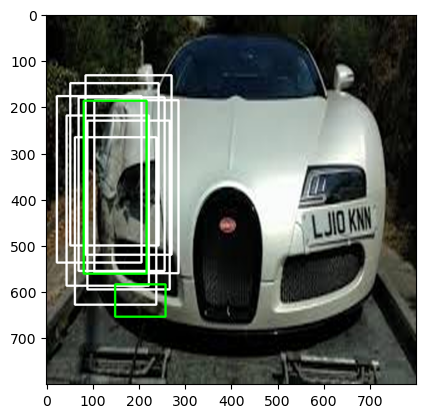

In [72]:
img_clone = np.copy(img)
for i in range(pos_roi_per_this_image):
    y0,x0,y1,x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone,(x0,y0),(x1,y1),(255,255,255),thickness=3)
    
for i in range(len(bbox)):
    cv2.rectangle(img_clone,(bbox[i][1],bbox[i][0]),(bbox[i][3],bbox[i][2]), color=(0,255,0),thickness=3)
    
plt.imshow(img_clone)
plt.show()

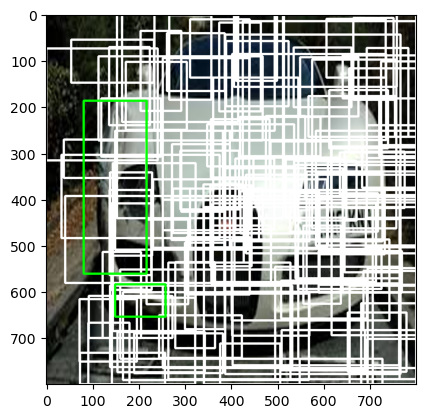

In [73]:
img_clone = np.copy(img)
for i in range(neg_roi_per_this_image):
    y0,x0,y1,x1 = roi[neg_index[i]].astype(int)
    cv2.rectangle(img_clone,(x0,y0),(x1,y1),(255,255,255),thickness=3)
    
for i in range(len(bbox)):
    cv2.rectangle(img_clone,(bbox[i][1],bbox[i][0]),(bbox[i][3],bbox[i][2]), color=(0,255,0),thickness=3)

plt.imshow(img_clone)
plt.show()

In [74]:
#we gather postive and negative index together.
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(128, 4)


In [75]:
#pick the ground truth objects for these roi that we keep.
bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)
 
height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width
base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)


In [76]:
#we transform our prediction back to the originate(dy,dx,dh,dw)
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs)

[[ 1.39572889e-01  5.30594129e-03  6.28548762e-02 -3.38788308e-01]
 [ 1.63356454e-02 -7.91214272e-02 -3.86492936e-03 -3.09852721e-01]
 [ 1.97856117e-03 -2.56834256e-01 -2.44997353e-04 -2.87350721e-01]
 [ 4.55955615e-02  1.86865596e-01  3.58674630e-02 -2.97914845e-01]
 [-8.01814299e-02  8.70019812e-02  1.43165218e-02 -2.72719738e-01]
 [-1.06272316e-01 -1.64856591e-01  2.31647193e-02 -2.73183550e-01]
 [-2.02536256e-01 -8.89964058e-03  3.00833374e-02 -2.53572555e-01]
 [ 1.22425072e-01 -1.58514104e-01 -3.58443304e-02 -3.14840295e-01]
 [ 1.53429890e+00 -1.80850586e+00  7.16801194e-01  4.11465639e-01]
 [ 7.26836591e-01  1.21835449e-01  1.49407169e+00 -2.71544177e-01]
 [-1.50173132e+00 -4.05239488e+00  5.63828917e-01 -5.02013153e-02]
 [-3.19613536e-01 -3.35414826e-01 -9.26018297e-01 -1.28588748e+00]
 [-2.04056152e+00 -2.94583869e+00  1.42617864e+00 -2.81152722e-01]
 [-6.18023958e-02 -3.36480490e+00  1.06997822e+00  6.04241101e-03]
 [ 1.03804953e+00 -7.68827603e+00  1.09977055e+00  5.36848622e

# FAST R-CNN

In [77]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [78]:
indices_and_rois = torch.cat((roi_indices[:, None], rois), dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


In [79]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [80]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio (we sampling each 16 pixel as 1 big-pixel ,so the picture size that originally 800 x 800 became 50x50)
rois = rois.long()#because the coordinate based on pixel cant be decimal , we must make it rounded.
store_im = []
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    #subset of the feature map based on the roi dimension
    im = out_map[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    store_im.append(im)
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
    
#output is list of 128 torch and we concatenate those 128 list of torch into 1 torch. 
output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


In [81]:
k = output.view(output.size(0), -1)
print(k.shape)

torch.Size([128, 25088])


In [82]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), 
                                      nn.Linear(4096, 4096)]).to(device)

#loc
cls_loc = nn.Linear(4096, 2 * 4).to(device) #(1 classes damaged + 1 background. Each will have 4 co-ordinates)
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

#score
score = nn.Linear(4096, 2).to(device) #(1 classes damaged + 1 background)

In [83]:
np.shape(rois)

torch.Size([128, 5])

In [84]:
# passing the output of roi-pooling to ROI head 
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)


torch.Size([128, 8]) torch.Size([128, 2])


In [85]:
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


torch.Size([128, 2])

In [86]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [88]:
import torch.nn.functional as F


gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([])
